# Data processing for re-entry sites.

1. Parse the space-track.org TIPs from the json export.
2. Clean and preprocess the data.


In [9]:
%pip install matplotlib pandas geopandas shapely geopy numpy geodatasets

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os

# Add each JSONs data to dataframe
df = pd.DataFrame()
for file in os.listdir("data/TIPs"):
    df = pd.concat([df, pd.read_json("data/TIPs/"+file)])

print(df.head())

   NORAD_CAT_ID            MSG_EPOCH         INSERT_EPOCH  \
0            60  2012-03-24 15:19:00  2012-03-24 09:23:00   
1            60  2012-03-25 03:50:00  2012-03-24 21:55:48   
2            60  2012-03-26 04:36:00  2012-03-25 22:40:37   
3            60  2012-03-27 03:47:00  2012-03-26 21:50:52   
4            60  2012-03-27 14:54:00  2012-03-27 09:00:14   

           DECAY_EPOCH  WINDOW    REV   DIRECTION   LAT    LON  INCL  \
0  2012-03-28 03:04:00    2880  58623   ascending -42.7   13.3  49.9   
1  2012-03-28 04:18:00    2880  58624  descending -41.2  272.6  49.9   
2  2012-03-28 03:39:00    1440  58624   ascending  48.3  125.8  49.9   
3  2012-03-28 02:47:00     840  58624  descending -33.4  282.0  49.9   
4  2012-03-28 02:23:00     420  58623  descending  38.7  212.3  49.9   

   NEXT_REPORT    ID HIGH_INTEREST  OBJECT_NUMBER  
0           72  3007             N             60  
1           48  3010             N             60  
2           24  3013             N          

In [2]:
from shapely.geometry import Polygon, Point
from geopy.distance import geodesic, great_circle
import geopandas as gpd
import numpy as np
import geodatasets

THRESHOLD = 10

df = df.sort_values(by=['OBJECT_NUMBER', 'INSERT_EPOCH'])

# Group by 'OBJECT_NUMBER' and take the last entry for each group
last_tips = df.groupby('OBJECT_NUMBER').tail(1).reset_index(drop=True)

def get_reentry_region(tip):
    # TODO: This could get adjusted based on the spacecraft/debris data (mass, speed, altitude, etc.)

    center = (tip.LAT, tip.LON)
    
    # Define the radius of the circle in kilometers (e.g., 11 km)
    radius_km = THRESHOLD * (1 + tip.INCL / 90)

    # Generate points around the center at different bearings
    num_points = 10  # number of points to define the circle
    angles = np.linspace(0, 360, num_points)
    circle_points = []

    for angle in angles:
        destination = geodesic(kilometers=radius_km).destination(center, angle)
        # Note: geopy returns (latitude, longitude); Polygon expects (longitude, latitude)
        circle_points.append((destination.longitude, destination.latitude))

    # Create a polygon from the generated points
    geodesic_circle = Polygon(circle_points)

    return geodesic_circle

# get the polygons for all land on earth
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))
# Combine all countries into one MultiPolygon representing land
land_polygon = world.union_all()

def reentry_near_land(tip, threshold_km=THRESHOLD):
    region = get_reentry_region(tip)

    if region.intersects(land_polygon):
        return (True, 0)
    
    distance_deg = region.distance(land_polygon)
    distance_km = distance_deg * 111.321
    return (False, distance_km)

near_reentries = []

for tip in last_tips.itertuples(index=True):
    if reentry_near_land(tip)[0]:
        near_reentries.append(tip)


In [3]:
print(f"Maximum distance threshold: {THRESHOLD}km")
print(f"Total number of near-land re-entries: {len(near_reentries)}")
print(f"Total number of re-entries: {len(last_tips)}")
print(f"Percentage of near-land re-entries: {len(near_reentries) / len(last_tips) * 100:.2f}%")

Maximum distance threshold: 10km
Total number of near-land re-entries: 693
Total number of re-entries: 2489
Percentage of near-land re-entries: 27.84%


In [4]:
# Load major world cities dataset
# Using Natural Earth 'populated places' dataset (~10,000 cities)
cities = gpd.read_file("data/110m_cultural/ne_110m_populated_places.shp")

# Keep only large cities (population > 500,000 for metropolises)
cities = cities[cities['POP_MAX'] > 100000] 

# Sort cities by population to prioritize bigger cities when distances are similar
cities = cities.sort_values(by="POP_MAX", ascending=False)  


def find_nearest_metropolis(lat, lon, max_distance_km=300):
    """Finds the nearest major city to the given (lat, lon) point"""
    nearest_city = None
    min_distance = float("inf")

    for _, city in cities.iterrows():
        city_coords = (city.geometry.y, city.geometry.x)  # (lat, lon)
        distance = great_circle((lat, lon), city_coords).km

        if distance < min_distance and distance <= max_distance_km:
            min_distance = distance
            nearest_city = city

    return nearest_city, min_distance

In [5]:
# Process each reentry and find the closest major city

near_city_reentries = []

for tip in last_tips.itertuples(index=True):
    reentry_point = (tip.LAT, tip.LON)
    nearest_city, distance = find_nearest_metropolis(*reentry_point)

    if nearest_city is not None:
        print(f"Object {tip.OBJECT_NUMBER} re-entered {round(distance)}km away from {nearest_city.NAME} ({nearest_city.ADM0NAME}) at {tip.DECAY_EPOCH}.")
        near_city_reentries.append(tip)


Object 63 re-entered 232km away from Asunción (Paraguay) at 2014-05-18 04:50:00.
Object 6792 re-entered 170km away from Niamey (Niger) at 2020-02-25 13:31:00.
Object 9911 re-entered 152km away from Athens (Greece) at 2014-08-04 08:29:00.
Object 11474 re-entered 272km away from Bloemfontein (South Africa) at 2017-10-23 14:38:00.
Object 12154 re-entered 283km away from Lisbon (Portugal) at 2014-05-08 19:52:00.
Object 12155 re-entered 180km away from Dakar (Senegal) at 2024-08-23 12:42:00.
Object 14694 re-entered 224km away from Nassau (The Bahamas) at 2014-12-23 07:55:00.
Object 19485 re-entered 256km away from Bujumbura (Burundi) at 2008-08-02 02:45:00.
Object 22312 re-entered 216km away from Bujumbura (Burundi) at 2006-04-04 14:02:00.
Object 23236 re-entered 212km away from Juba (South Sudan) at 2004-09-27 16:16:00.
Object 23246 re-entered 265km away from Dili (East Timor) at 2007-09-06 00:50:00.
Object 24968 re-entered 226km away from Dushanbe (Tajikistan) at 2018-05-26 01:46:00.
Obje

In [15]:
print(len(near_city_reentries))

241


In [6]:
import requests

def fetch_globe_measurements(protocols, start_date, end_date, lat, lon, threshold, sample=True):
    # /v1/measurement/protocol/measureddate/point/distance/
    url = "https://api.globe.gov/search/v1/measurement/protocol/measureddate/lat/lon/"
    measurements = []

    params = {
        "protocols": ','.join(protocols),
        "startdate": start_date,
        "enddate": end_date,
        "minlat": lat-threshold,
        "maxlat": lat+threshold,
        "minlon": lon-threshold,
        "maxlon": lon+threshold,
        "geojson": "FALSE",
        "sample": "TRUE" if sample else "FALSE",
    }

    res = requests.get(url, params=params)

    if res.status_code == 200:
        return res.json()
    else:
        print(f"Error: {res.status_code} - {res.text}")
    
protocols = ["air_temps", "humidities", "dissolved_oxygens"]

measurements = []

for i, reentry in enumerate(near_city_reentries):
    decay_epoch = pd.to_datetime(reentry.DECAY_EPOCH)
    start_date = (decay_epoch - pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")
    end_date = (decay_epoch + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")
    data = fetch_globe_measurements(protocols, start_date, end_date, reentry.LAT, reentry.LON, threshold=10, sample=False)

    if data['count'] > 0:
        measurements.append((reentry.DECAY_EPOCH, f"NORAD {reentry.OBJECT_NUMBER}", data, (reentry.LAT, reentry.LON)))

print(f"Got data for {len(measurements)} sites.")

Got data for 108 sites.


In [7]:
import json

with open("outputs/measurements.json", 'w') as file:
    json.dump(measurements, file)

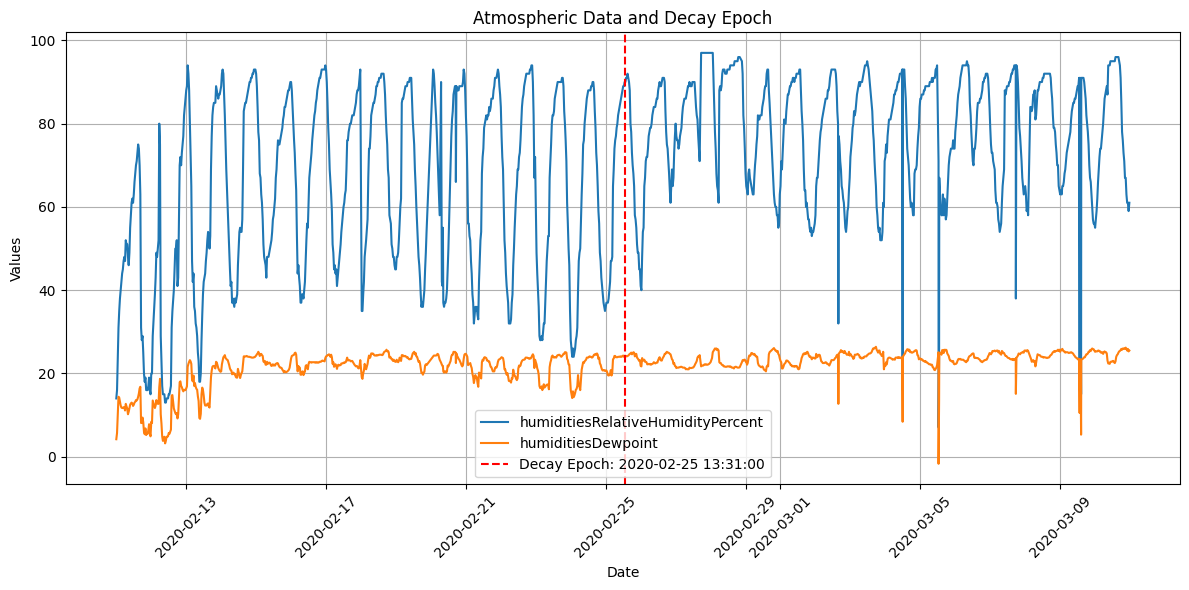

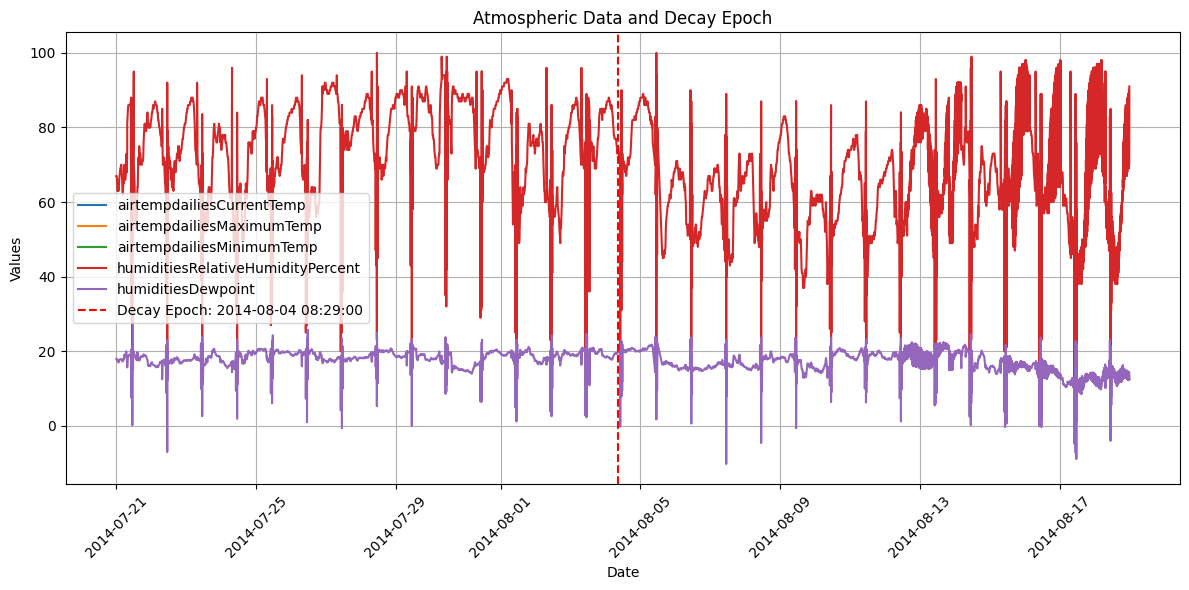

In [ ]:
#plot_atmospheric_data(measurements[0], near_city_reentries[measurements[0][0]].DECAY_EPOCH)

# plot each measurement in the list

for i, m in enumerate(measurements):
    plot_atmospheric_data(m, near_city_reentries[m[0]].DECAY_EPOCH)